# Caso de Negocio: Estimación de Costos de Equipos para Proyecto de Construcción

## Importacion de librerias, lectura y procesamiento de los datos

In [112]:
## IMPORTACION DE LIBRERIAS GENERALES

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import model_selection
from sklearn import neural_network
from sklearn.utils.validation import check_is_fitted
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numbers import Number


In [113]:
# Ruta de la carpeta donde están los archivos
carpeta = ""#notebook en la carpeta donde están los datos, en caso contrario incluir entre las comillas el camino de la carpeta donde se hayan.

# Nombres de los archivos
archivos = ["X.csv", "Y.csv", "Z.csv"]

# Leer cada archivo y guardarlo en un dataframe con el delimitador adecuado
df_X = pd.read_csv(f"{carpeta}{archivos[0]}", sep=",", header=0)
df_Y = pd.read_csv(f"{carpeta}{archivos[1]}", sep=";", header=0)
df_Z = pd.read_csv(f"{carpeta}{archivos[2]}", sep=",", header=0)


In [114]:
### FUNCION PARA LIMPIEZA DE DATAFRAMES

def procesar_dataframe(df, date_col, price_col, date_format):
    # Renombrar columnas para uniformidad
    df = df.rename(columns={date_col: "Date", price_col: "Price"})

    # Formatear la columna de fecha al formato estándar YYYY-MM-DD
    df["Date"] = pd.to_datetime(df["Date"], format=date_format, errors="coerce")

    # Limpiar y convertir la columna de precio a float
    df["Price"] = df["Price"].replace(",", "", regex=True).astype(float)

    return df

In [115]:
### PROCESAMIENTO DE DATAFRAMES

# Procesar cada DataFrame
df_X = procesar_dataframe(df_X, date_col="Date", price_col="Price", date_format="%Y-%m-%d")
df_Y = procesar_dataframe(df_Y, date_col="Date", price_col="Price", date_format="%d/%m/%Y")
df_Z = procesar_dataframe(df_Z, date_col="Date", price_col="Price", date_format="%Y-%m-%d")

# Renombrar las columnas de precio para fusionar
df_X = df_X.rename(columns={"Price": "Price_X"})
df_Y = df_Y.rename(columns={"Price": "Price_Y"})
df_Z = df_Z.rename(columns={"Price": "Price_Z"})

# Combinar los DataFrames por fecha
df_merged = pd.merge(df_X, df_Y, on="Date", how="outer")
df_merged = pd.merge(df_merged, df_Z, on="Date", how="outer")


Se buscan los valores nulos dentro de df_merge, los cuales se generan al unir los datos de cada materia prima.

In [116]:
df_merged.isna().sum()

Date          0
Price_X      49
Price_Y    4708
Price_Z    5628
dtype: int64

Debido a la cantidad de datos nulos, se eliminaran para contar solo con los dias que si aportan al precio del equipo 1 y 2.

In [117]:
df_merged = df_merged.sort_values("Date").reset_index(drop=True)
df_merged.dropna(inplace=True)
df_merged=df_merged.set_index('Date')
df_merged.head()

,Price_X,Price_Y,Price_Z
Date,,,
2010-01-04,80.12,5275.0,2225.25
2010-01-05,80.59,5275.0,2246.50
2010-01-06,81.89,5275.0,2302.50
2010-01-07,81.51,5275.0,2306.50
2010-01-08,81.37,5525.0,2261.25


In [118]:
df_merged.isna().sum()

Price_X    0
Price_Y    0
Price_Z    0
dtype: int64

In [119]:
# Agrupar por "Year-Month" y calcular los valores promedio para cada columna de precio
# Crear la columna "Year-Month" a partir de la fecha del índice
df_merged["Year-Month"] = df_merged.index.strftime("%Y-%m")

# Ahora sí, agrupar por "Year-Month"
df_monthly_avg = df_merged.groupby("Year-Month").mean(numeric_only=True).reset_index()

# Renombrar las columnas para que coincidan con el formato deseado
df_monthly_avg = df_monthly_avg.rename(
    columns={
        "Year-Month": "Date",
        "Price_X": "avg_price_X",
        "Price_Y": "avg_price_Y",
        "Price_Z": "avg_price_Z",
    }
)

# Formatear "Date" como un string para mejorar la presentación
df_monthly_avg["Date"] = df_monthly_avg["Date"].astype(str)
df_monthly_avg.head()

,Date,avg_price_X,avg_price_Y,avg_price_Z
0,2010-01,77.013000,2983.750000,2234.325000
1,2010-02,74.790000,1514.500000,2048.575000
2,2010-03,79.931304,1746.304348,2204.130435
3,2010-04,85.753810,2145.476190,2313.083333
4,2010-05,76.997619,2163.571429,2048.666667


In [120]:
# Renombramos el dataset
df_merged=df_monthly_avg

In [121]:
### CALCULAR PRECIO POR EQUIPOS
#Para el equipo 1, el precio es el 20% de la materia prinma X (multiplicar por 0.2) y el resto por la matria prima Y (0.8)
#Para el equipo 2, Son partes iguales de cada materia , es decir 1/3 de cada una
#Ademas se crea una columba para cada equipo con su correspondiente valor
df_merged["Equipo_1"] = 0.2 * df_merged["avg_price_X"] + 0.8 * df_merged["avg_price_Y"]
df_merged["Equipo_2"] = (df_merged["avg_price_X"] + df_merged["avg_price_Y"] + df_merged["avg_price_Z"]) / 3


Quiero agrupar por meses el promedio de cada dato

In [122]:
df_merged.head()

,Date,avg_price_X,avg_price_Y,avg_price_Z,Equipo_1,Equipo_2
0,2010-01,77.013000,2983.750000,2234.325000,2402.402600,1765.029333
1,2010-02,74.790000,1514.500000,2048.575000,1226.558000,1212.621667
2,2010-03,79.931304,1746.304348,2204.130435,1413.029739,1343.455362
3,2010-04,85.753810,2145.476190,2313.083333,1733.531714,1514.771111
4,2010-05,76.997619,2163.571429,2048.666667,1746.256667,1429.745238


In [123]:
df_merged.isna().sum()

Date           0
avg_price_X    0
avg_price_Y    0
avg_price_Z    0
Equipo_1       0
Equipo_2       0
dtype: int64

C:\Users\pinto\AppData\Local\Temp\ipykernel_24208\2264778746.py:7: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(df_merged["Date"], df_merged['Equipo_1'], linestyle='-', marker='o',  alpha=0.7, label="Precio Equipo 1")
C:\Users\pinto\AppData\Local\Temp\ipykernel_24208\2264778746.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(df_merged["Date"], df_merged['Equipo_1'], linestyle='-', marker='o',  alpha=0.7, label="Precio Equipo 1")
C:\Users\pinto\AppData\Local\Temp\ipykernel_24208\2264778746.py:8: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(df_merged["Date"], df_merged["Equipo_2"], linestyle='-', marker='o', alpha=0.7, label="Precio Equipo 2")
C:\Users\

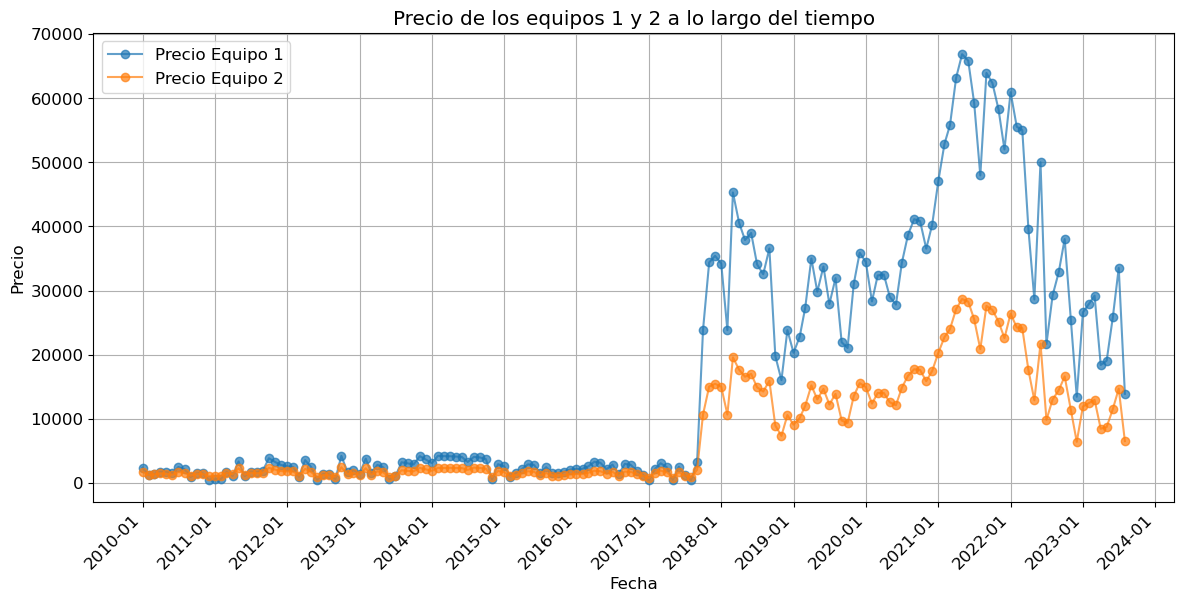

In [124]:

#arregla el formato de la columna date
df_merged["Date"] = pd.to_datetime(df_merged["Date"])

plt.figure(figsize=(12, 6))

# se imprimen con las fechas
plt.plot_date(df_merged["Date"], df_merged['Equipo_1'], linestyle='-', marker='o',  alpha=0.7, label="Precio Equipo 1")
plt.plot_date(df_merged["Date"], df_merged["Equipo_2"], linestyle='-', marker='o', alpha=0.7, label="Precio Equipo 2")

plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.legend()
plt.grid()

# Se asigna al eje x solo los primeros meses de cada mes:
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Tick every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # Format as 'Year-Month'

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.rcParams.update({'font.size': 12})
plt.title("Precio de los equipos 1 y 2 a lo largo del tiempo")
plt.show()

In [125]:
df_merged_e1= df_merged.drop(columns=["Equipo_2","avg_price_X","avg_price_Y","avg_price_Z"])
df_merged_e2= df_merged.drop(columns=["Equipo_1","avg_price_X","avg_price_Y","avg_price_Z"])
df_merged_e1.sample(5)

,Date,Equipo_1
47,2013-12-01,3665.568952
162,2023-07-01,33521.784381
21,2011-10-01,3860.043048
72,2016-01-01,2178.385100
153,2022-10-01,38028.070000


## Definición de las funciones necesarias para el modelo
Se contemplan aqui las siguientes funciones.
* temporal_split: Divide el conjunto de datos en conjuntos de entrenamiento y prueba
* temporal_window: Convierte una serie temporal en matrices con ventanas
* train_time_series_mlp: Entrena un modelo con una búsqueda de hiperparámetros
* predict_n_future_values: Predice los próximos n valores utilizando un modelo entrenado

In [126]:
def temporal_split(series, p):
  """
  Separa una serie de tiempo en un conjunto de entrenamiento y prueba temporalmente.
  Entradas:
    series : Arreglo de NumPy con shape (n,) con la serie de tiempo.
    p :porcentaje de datos destinados para la partición de prueba
  Retorna:
    series_train: Arreglo de NumPy con partición de entrenamiento de la serie de tiempo.
    series_test: Arreglo de NumPy con partición de prueba de la serie de tiempo.
  """

  n=round(len(series)*(1-p))
  series_train = series[:n]
  series_test = series[n:]


  return series_train, series_test

In [127]:
df_merged_e1.iloc[:,1]

0       2402.402600
1       1226.558000
2       1413.029739
3       1733.531714
4       1746.256667
           ...     
159    18398.273789
160    19073.330261
161    25821.468455
162    33521.784381
163    13905.368696
Name: Equipo_1, Length: 164, dtype: float64

Usaremos una red neuronal (perceptrón multicapa) para el entrenamiento. la función train_time_series_mlp entrena y retorna un objeto GridSearchCV como resultado de la exploración de hiperparámetros del regresor perceptrón multicapa. Para garantizar la reproducibilidad de su resultado, se le entregará además el argumento seed, que se usa como semilla aleatoria en el entrenamiento del regresor (en el constructor del regresor base).

In [128]:

def train_time_series_mlp(X_train, y_train, param_grid, k,seed = 30303):
  """
  Entradas:
    X_train: Arreglo de numpy con shape (n, m)
    y_train: Arreglo de numpy con shape (n,)
    param_grid: Hiperparámetros a explorar
    k: Número de divisiones para TimeSeriesSplit.
    seed: Semilla aleatoria para la creación de la partición.
  Retorna:
    gsearch: GridSearchCV entrenado con X_train y y_train.
  """

  # Declare el regresor base del modelo perceptrón multicapa.
  # IMPORTANTE: Fije la seed aleatoria con el argumento 'random_state'.

  mlp = neural_network.MLPRegressor(random_state=seed)
  # Declare y entrene el objeto GridSearchCV.
  tss=model_selection.TimeSeriesSplit(n_splits=k)
  gsearch = model_selection.GridSearchCV(mlp, param_grid, cv=tss)
  gsearch.fit(X_train, y_train)

  return gsearch

Con el mejor regresor entrenado podemos empezar a realizar predicciones de los próximos precios de los equipos. Para esto, utilizamos una ventana de valores previos para indicarle a nuestro regresor el estado previo de la serie de tiempo y poder obtener la predicción del siguiente valor.

In [129]:
def temporal_window(series, w):
  """
  Recibe una serie de tiempo series y genere una matriz con las ventanas de tiempo de tamaño w en formato X, y.
  Entradas:
    series: Arreglo de NumPy con tamaño (n,), una serie de tiempo
    w: Número entero, tamaño de las ventanas de tiempo.
  Retorna:
    X: Arreglo de NumPy con shape(n - w, w), las ventanas temporales.
    y: Arreglo de NumPy con shape(n - w,), el valor siguiente en la serie para cada ventana.
  """
  # Select only the numeric column ('Equipo_1') for windowing
  series_values = series.iloc[:,1].values.flatten()
  X = np.empty((len(series_values) - w, w))
  y = np.empty(len(series_values) - w)
  for i in range(len(series_values) - w):
    X[i] = series_values[i:i + w]  # Assigning the windowed values
    y[i] = series_values[i + w]  # Assigning the target value
  return X, y

Ahora vamos a explorar los hiperparámetros de la red para identificar sus valores más apropiados. Para hacer esto, utilizaremos todas las particiones generadas por TimeSeriesSplit y exploraremos manualmente las combinaciones de hiperparámetros de MLPRegressor.

In [130]:
def next_value(model, window):
  """
  Entradas:
    model: modelo de regresión de Scikit-Learn entrenado.
    window: arreglo de NumPy con shape (w,) donde w es el tamaño de la ventana.
  Retorna:
    next: el valor de la predicción con el siguiente valor a la ventana.
  """
  next = model.predict(window.reshape(1,-1))[0]

  ### FIN DEL CÓDIGO ###
  return next

Para finalizar, realizaremos una predicción de  n  valores futuros de manera autorregresiva (a partir de ventanas predichas por el modelo) y lo compararemos de manera gráfica con la partición de prueba.

In [131]:
def predict_n_future_values(model, window, n):
  """
  Entradas:
    model: modelo de regresión entrenado con w características de entrada.
    window: arreglo de NumPy con tamaño (w,)
    n:número de pasos temporales a predecir.
  Retorna:
    pred: arreglo de NumPy con tamaño (n,) con la predicción de los siguientes n valores
  """
  pred=np.array([])
  for i in range(n):
    pred=np.append(pred,next_value(model,window))
    window=np.delete(window,0)
    window=np.append(window,pred[i])

  return pred

## Implementación de las funciones e implementacion del modelo (perceptrón).

c:\Users\pinto\anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pinto\anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


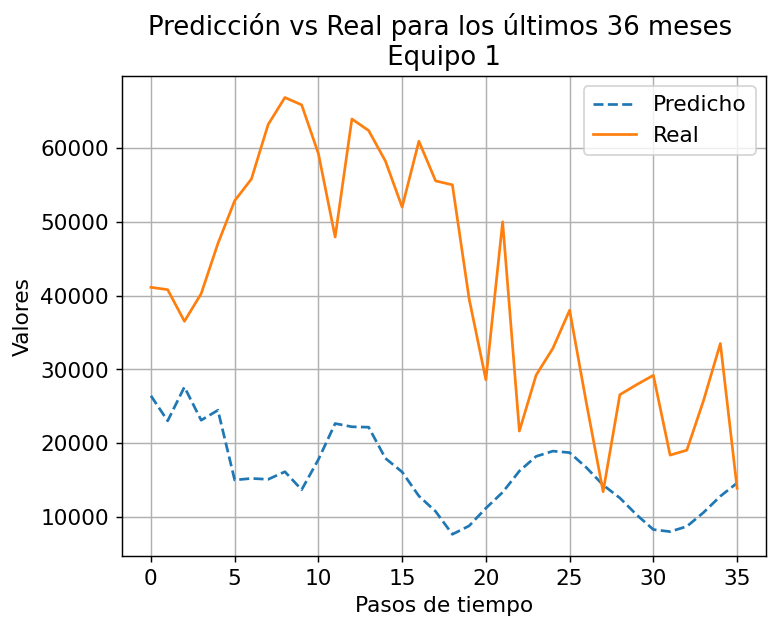

In [132]:
# Definir el tamaño de la ventana y el horizonte de predicción
window_size = 12  # Tamaño de la ventana temporal
n = 36  # Número de meses a predecir

# Suponiendo que las siguientes funciones y datos están predefinidos:
# - temporal_split: Divide el conjunto de datos en conjuntos de entrenamiento y prueba
# - temporal_window: Convierte una serie temporal en matrices con ventanas
# - train_time_series_mlp: Entrena un modelo con una búsqueda de hiperparámetros
# - predict_n_future_values: Predice los próximos n valores utilizando un modelo entrenado
# - df_merged_e1: El conjunto de datos con el que se trabaja

# Paso 1: Generar particiones de entrenamiento y prueba
X_train, X_test = temporal_split(df_merged_e1, p=0.3)

# Paso 2: Transformar la serie temporal en ventanas de tiempo
X_train_window, y_train_window = temporal_window(X_train, window_size)
X_test_window, y_test_window = temporal_window(X_test, window_size)

# Paso 3: Entrenar el modelo con la búsqueda de hiperparámetros
param_grid = {
    "hidden_layer_sizes": [(40,), (80,)],
    "max_iter": [500],
    "solver": ["adam"],
    "activation": ["relu"]
}

gsearch = train_time_series_mlp(X_train_window, y_train_window, param_grid, 3)

# Paso 4: Usar la última ventana del conjunto de prueba para la predicción
last_window = X_test_window[-1]  # Seleccionar dinámicamente la última ventana

# Paso 5: Obtener los valores reales de los últimos n meses
y_true = y_test_window[-n:]  # Últimos n valores reales

# Paso 6: Predecir los próximos n valores usando el modelo entrenado
y_pred_mlp_e1 = predict_n_future_values(gsearch, last_window, n)

# Paso 7: Graficar las predicciones y los valores reales
plt.figure(dpi=130)
plt.plot(y_pred_mlp_e1, label="Predicho", linestyle="--",)
plt.plot(y_true, label="Real", linestyle="-")
plt.legend()
plt.title("Predicción vs Real para los últimos 36 meses \n Equipo 1 ")
plt.xlabel("Pasos de tiempo")
plt.ylabel("Valores")
plt.grid(True)
plt.show()


In [133]:
# Calcular las métricas de evaluación
mae = mean_absolute_error(y_true[:len(y_pred_mlp_e1)], y_pred_mlp_e1)
rmse_mlp1 = np.sqrt(mean_squared_error(y_true[:len(y_pred_mlp_e1)], y_pred_mlp_e1))

print(f"MAE (Error Absoluto Medio): {mae:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse_mlp1:.4f}")

MAE (Error Absoluto Medio): 25813.5483
RMSE (Raíz del Error Cuadrático Medio): 30033.1917


Se implemeta de la misma forma para el equipo 2.

c:\Users\pinto\anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


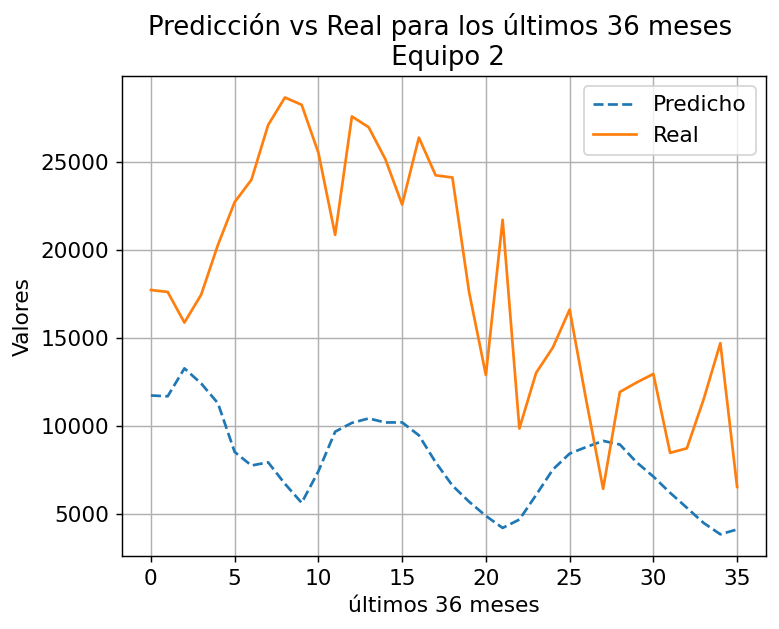

In [134]:
# Paso 1: Generar particiones de entrenamiento y prueba
X_train, X_test = temporal_split(df_merged_e2, p=0.3)

# Paso 2: Transformar la serie temporal en ventanas de tiempo
X_train_window, y_train_window = temporal_window(X_train, window_size)
X_test_window, y_test_window = temporal_window(X_test, window_size)

# Paso 3: Entrenar el modelo con la búsqueda de hiperparámetros
param_grid = {
    "hidden_layer_sizes": [(40,), (80,)],
    "max_iter": [500],
    "solver": ["adam"],
    "activation": ["relu"]
}

gsearch = train_time_series_mlp(X_train_window, y_train_window, param_grid, 3)

# Paso 4: Usar la última ventana del conjunto de prueba para la predicción
last_window = X_test_window[-1]  # Seleccionar dinámicamente la última ventana

# Paso 5: Obtener los valores reales de los últimos n meses
y_true = y_test_window[-n:]  # Últimos n valores reales

# Paso 6: Predecir los próximos n valores usando el modelo entrenado
y_pred_mlp_e2 = predict_n_future_values(gsearch, last_window, n)

# Paso 7: Graficar las predicciones y los valores reales
plt.figure(dpi=130)
plt.plot(y_pred_mlp_e2, label="Predicho", linestyle="--")
plt.plot(y_true, label="Real", linestyle="-")
plt.legend()
plt.title("Predicción vs Real para los últimos 36 meses \n Equipo 2")
plt.xlabel("últimos 36 meses")
plt.ylabel("Valores")
plt.grid(True)
plt.show()


In [135]:
# Calcular las métricas de evaluación
mae = mean_absolute_error(y_true[:len(y_pred_mlp_e2)], y_pred_mlp_e2)
rmse_mlp2 = np.sqrt(mean_squared_error(y_true[:len(y_pred_mlp_e2)], y_pred_mlp_e2))

print(f"MAE (Error Absoluto Medio): {mae:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse_mlp2:.4f}")

MAE (Error Absoluto Medio): 10383.0278
RMSE (Raíz del Error Cuadrático Medio): 12085.6202


## Implementación del modelo LSTM 

In [136]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

seed = 1
tf.random.set_seed(seed)  # Fijar semilla aleatoria para reproducibilidad

In [137]:
def create_lstm_sequences(series, window_size):
    """
    Transforma una serie temporal en secuencias compatibles con LSTM (X, y).
    
    Parámetros:
        series: Un arreglo de NumPy o una Serie de Pandas que contiene los datos de la serie temporal.
        window_size: El tamaño de la ventana deslizante.
    
    Retorna:
        X: Arreglo 3D de NumPy con forma (n_samples, window_size, 1), las secuencias de entrada.
        y: Arreglo 1D de NumPy con forma (n_samples,), los valores objetivo.
    """
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])  # Ventana deslizante
        y.append(series[i + window_size])   # Siguiente valor (objetivo)
    
    X = np.array(X).reshape(-1, window_size, 1)  # Redimensionar a 3D
    y = np.array(y)
    return X, y


In [138]:
def train_lstm(X_train, y_train, window_size, n_neurons=50, epochs=50, batch_size=32, seed_lstm=seed):
    """
    Entrena un modelo LSTM para la predicción de series temporales.
    
    Parámetros:
        X_train: Arreglo 3D de NumPy con forma (n_samples, window_size, 1), las secuencias de entrenamiento.
        y_train: Arreglo 1D de NumPy con forma (n_samples,), los valores objetivo.
        window_size: El tamaño de la secuencia de entrada (número de pasos de tiempo).
        n_neurons: Número de neuronas en la capa LSTM.
        epochs: Número de épocas de entrenamiento.
        batch_size: Tamaño del lote para el entrenamiento.
        seed: Semilla aleatoria para garantizar reproducibilidad.
    
    Retorna:
        model: El modelo LSTM entrenado.
    """
    tf.random.set_seed(seed_lstm)  # Fija la semilla aleatoria para reproducibilidad
    
    # Definir el modelo LSTM
    model = Sequential([
        LSTM(n_neurons, activation='relu', input_shape=(window_size, 1)),  # Capa LSTM con activación ReLU
        Dense(1)  # Capa de salida para regresión
    ])
    
    # Compilar el modelo
    model.compile(optimizer='adam', loss='mse')  # Optimizador Adam y pérdida MSE
    
    # Entrenar el modelo con parada temprana
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)  # Configuración de parada temprana
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=1)
    
    return model


In [139]:
def predict_n_future_values_lstm(model, window, n):
    """
    Predice los próximos n valores utilizando un modelo LSTM entrenado.
    
    Parámetros:
        model: El modelo LSTM entrenado.
        window: Un arreglo 3D de NumPy con forma (1, window_size, 1), la última secuencia observada.
        n: Número de pasos futuros a predecir.
    
    Retorna:
        pred: Un arreglo de NumPy con forma (n,), los valores predichos.
    """
    pred = []
    for _ in range(n):
        next_value = model.predict(window, verbose=0)[0][0]  # Predecir el siguiente valor
        pred.append(next_value)
        
        # Actualizar la ventana: Eliminar el valor más antiguo y agregar el valor predicho
        window = np.append(window[:, 1:, :], [[[next_value]]], axis=1)
    
    return np.array(pred)



### Implementacíon para el equipo 1

In [140]:
# Paso 1: Filtrar el conjunto de datos para comenzar desde una fecha específica
df_filtered = df_merged_e1

# Paso 2: Dividir en conjuntos de entrenamiento y prueba
X_train_series, X_test_series = temporal_split(df_filtered["Equipo_1"].values, p=0.2)

# Paso 3: Crear secuencias compatibles con LSTM
window_size = 10
X_train, y_train = create_lstm_sequences(X_train_series, window_size)
X_test, y_test = create_lstm_sequences(X_test_series, window_size)

# Paso 4: Entrenar el modelo LSTM
lstm_model = train_lstm(X_train, y_train, window_size, n_neurons=50, epochs=50, batch_size=32)



# Paso 5: Predecir los próximos n valores
# Usar la última ventana del conjunto de prueba para realizar predicciones
last_window = X_test[-1].reshape(1, window_size, 1)  # Redimensionar para la entrada al LSTM
n = 36  # Número de pasos a predecir
y_pred_lstm_1 = predict_n_future_values_lstm(lstm_model, last_window, n)


Epoch 1/50
4/4 [==============================] - 1s 11ms/step - loss: 388349600.0000
Epoch 2/50
4/4 [==============================] - 0s 6ms/step - loss: 242145552.0000
Epoch 3/50
4/4 [==============================] - 0s 6ms/step - loss: 213529328.0000
Epoch 4/50
4/4 [==============================] - 0s 6ms/step - loss: 194552160.0000
Epoch 5/50
4/4 [==============================] - 0s 6ms/step - loss: 180205408.0000
Epoch 6/50
4/4 [==============================] - 0s 8ms/step - loss: 163605360.0000
Epoch 7/50
4/4 [==============================] - 0s 3ms/step - loss: 128743032.0000
Epoch 8/50
4/4 [==============================] - 0s 6ms/step - loss: 114347656.0000
Epoch 9/50
4/4 [==============================] - 0s 0s/step - loss: 115593632.0000
Epoch 10/50
4/4 [==============================] - 0s 0s/step - loss: 99790008.0000
Epoch 11/50
4/4 [==============================] - 0s 0s/step - loss: 82109464.0000
Epoch 12/50
4/4 [==============================] - 0s 368us/step - 

Gráfica corregida

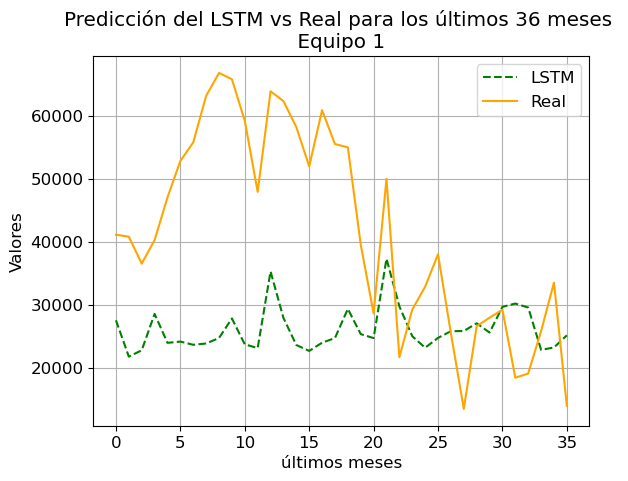

In [141]:
# Paso 5: Obtener los valores reales de los últimos n meses
#y_true = y_test_window[-n:]  # Últimos n valores reales
y_true = df_filtered.tail(36)["Equipo_1"]


# Paso 7: Graficar las predicciones y los valores reales
plt.figure()
x_axis = range(len(y_true))
plt.plot(x_axis, y_pred_lstm_1, label="LSTM", linestyle="--", color="green")
plt.plot(x_axis, y_true, label="Real", linestyle="-", color="orange")
plt.legend()
plt.title("Predicción del LSTM vs Real para los últimos 36 meses \n Equipo 1 ")
plt.xlabel("últimos meses")
plt.ylabel("Valores")
plt.grid(True)
plt.show()

In [142]:
# Calcular las métricas de evaluación
mae = mean_absolute_error(y_true[:len(y_pred_lstm_1)], y_pred_lstm_1)
rmse_lstm1 = np.sqrt(mean_squared_error(y_true[:len(y_pred_lstm_1)], y_pred_lstm_1))

print(f"MAE (Error Absoluto Medio): {mae:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse_lstm1:.4f}")

MAE (Error Absoluto Medio): 18653.8346
RMSE (Raíz del Error Cuadrático Medio): 22574.5468


Comparemos los resultados de los 2 modelos

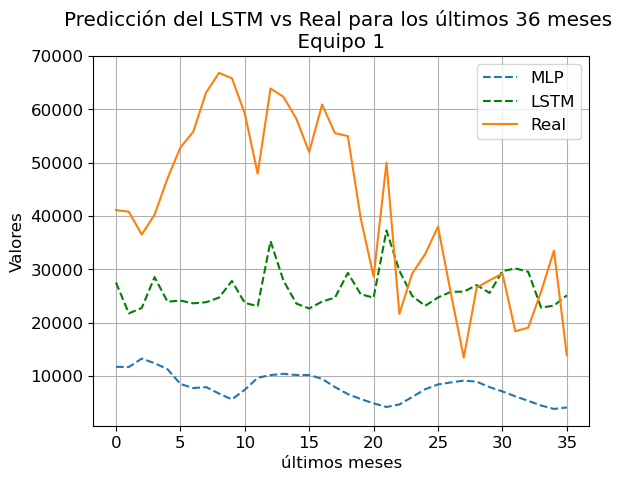

In [143]:
# Grafiquemos las predicciones de MLP, LSTM y los valores reales (equipo 2)
plt.figure()
x_axis = range(len(y_true))
plt.plot(x_axis, y_pred_mlp_e2, label="MLP", linestyle="--")
plt.plot(x_axis, y_pred_lstm_1, label="LSTM", linestyle="--", color="green")
plt.plot(x_axis, y_true, label="Real", linestyle="-")
plt.legend()
plt.title("Predicción del LSTM vs Real para los últimos 36 meses \n Equipo 1 ")
plt.xlabel("últimos meses")
plt.ylabel("Valores")
plt.grid(True)
plt.show()

### Implementación para el equipo 2

In [144]:
# Paso 1: Filtrar el conjunto de datos para comenzar desde una fecha específica
df_filtered = df_merged_e2

# Paso 2: Dividir en conjuntos de entrenamiento y prueba
X_train_series, X_test_series = temporal_split(df_filtered["Equipo_2"].values, p=0.2)

# Paso 3: Crear secuencias compatibles con LSTM
window_size = 10
X_train, y_train = create_lstm_sequences(X_train_series, window_size)
X_test, y_test = create_lstm_sequences(X_test_series, window_size)

# Paso 4: Entrenar el modelo LSTM
lstm_model = train_lstm(X_train, y_train, window_size, n_neurons=50, epochs=50, batch_size=32)



# Paso 5: Predecir los próximos n valores
# Usar la última ventana del conjunto de prueba para realizar predicciones
last_window = X_test[-1].reshape(1, window_size, 1)  # Redimensionar para la entrada al LSTM
n = 36  # Número de pasos a predecir
y_pred_lstm_2 = predict_n_future_values_lstm(lstm_model, last_window, n)


Epoch 1/50
4/4 [==============================] - 1s 5ms/step - loss: 66160508.0000
Epoch 2/50
4/4 [==============================] - 0s 5ms/step - loss: 65504620.0000
Epoch 3/50
4/4 [==============================] - 0s 6ms/step - loss: 64914704.0000
Epoch 4/50
4/4 [==============================] - 0s 0s/step - loss: 64352004.0000
Epoch 5/50
4/4 [==============================] - 0s 0s/step - loss: 63829652.0000
Epoch 6/50
4/4 [==============================] - 0s 0s/step - loss: 63313624.0000
Epoch 7/50
4/4 [==============================] - 0s 0s/step - loss: 62667560.0000
Epoch 8/50
4/4 [==============================] - 0s 0s/step - loss: 62086096.0000
Epoch 9/50
4/4 [==============================] - 0s 0s/step - loss: 61638900.0000
Epoch 10/50
4/4 [==============================] - 0s 0s/step - loss: 61178560.0000
Epoch 11/50
4/4 [==============================] - 0s 2ms/step - loss: 60686456.0000
Epoch 12/50
4/4 [==============================] - 0s 5ms/step - loss: 60175564.0

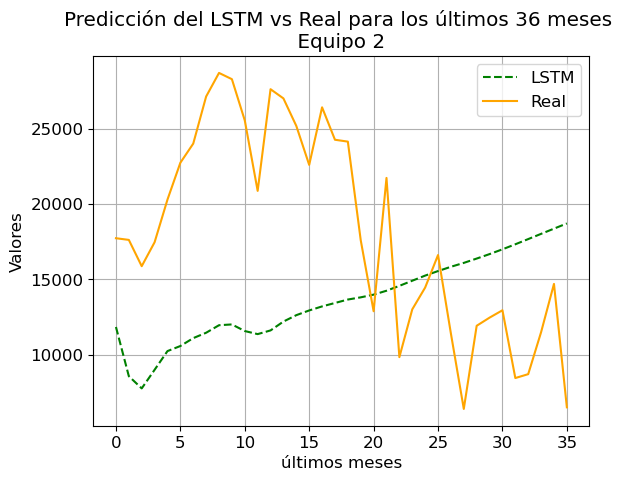

In [145]:
# Paso 5: Obtener los valores reales de los últimos n meses
#y_true = y_test_window[-n:]  # Últimos n valores reales
y_true = df_filtered.tail(36)["Equipo_2"]


# Paso 7: Graficar las predicciones y los valores reales
plt.figure()
x_axis = range(len(y_true))
plt.plot(x_axis, y_pred_lstm_2, label="LSTM", linestyle="--", color="green")
plt.plot(x_axis, y_true, label="Real", linestyle="-", color="orange")
plt.legend()
plt.title("Predicción del LSTM vs Real para los últimos 36 meses \n Equipo 2 ")
plt.xlabel("últimos meses")
plt.ylabel("Valores")
plt.grid(True)
plt.show()

In [146]:
# Calcular las métricas de evaluación
mae = mean_absolute_error(y_true[:len(y_pred_lstm_2)], y_pred_lstm_2)
rmse_lstm2 = np.sqrt(mean_squared_error(y_true[:len(y_pred_lstm_2)], y_pred_lstm_2))

print(f"MAE (Error Absoluto Medio): {mae:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse_lstm2:.4f}")

MAE (Error Absoluto Medio): 8717.8627
RMSE (Raíz del Error Cuadrático Medio): 9853.0600


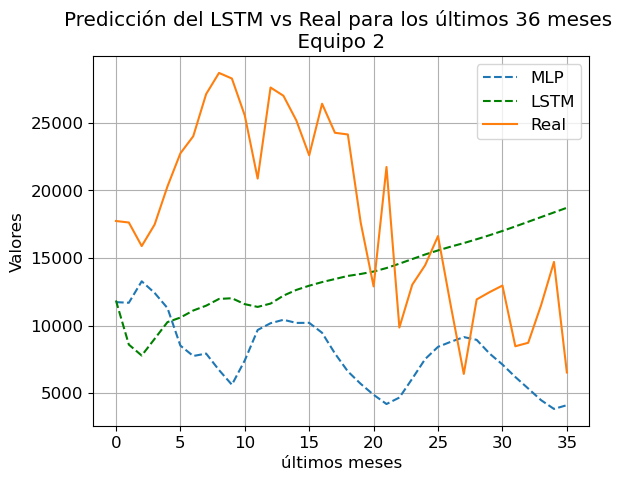

In [147]:
# Grafiquemos las predicciones de MLP, LSTM y los valores reales (equipo 2)
plt.figure()
x_axis = range(len(y_true))
plt.plot(x_axis, y_pred_mlp_e2, label="MLP", linestyle="--")
plt.plot(x_axis, y_pred_lstm_2, label="LSTM", linestyle="--", color="green")
plt.plot(x_axis, y_true, label="Real", linestyle="-")
plt.legend()
plt.title("Predicción del LSTM vs Real para los últimos 36 meses \n Equipo 2 ")
plt.xlabel("últimos meses")
plt.ylabel("Valores")
plt.grid(True)
plt.show()

Comparación de los errores

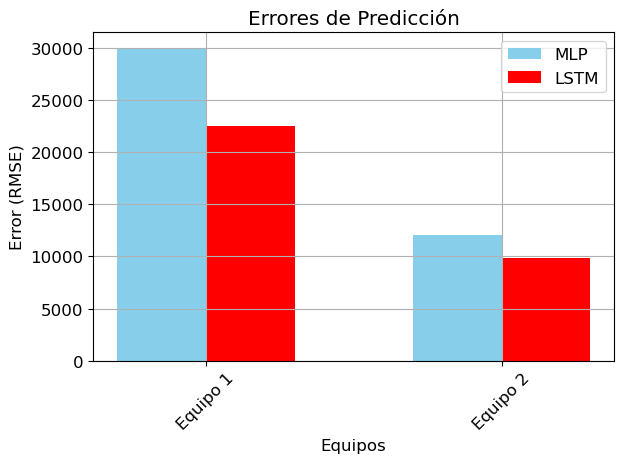

In [148]:

errors_mlp = [rmse_mlp1, rmse_mlp2] 
errors_lstm = [rmse_lstm1, rmse_lstm2]  

# Valores en el eje X para las barras del modelo MLP
x_vals_mlp = [0.3, 1.3]  

# Valores en el eje X para las barras del modelo LSTM
x_vals_lstm = [0.6, 1.6]  


labels = ['MLP Equipo 1', 'LSTM Equipo 1', 'MLP Equipo 2', 'LSTM Equipo 2']

# Ajustar las posiciones de las etiquetas del eje X para identificar equipos
plt.xticks([0.45, 1.45], ['Equipo 1', 'Equipo 2'], rotation=45)  


plt.bar(x_vals_mlp, errors_mlp, width=0.3, color='skyblue', label='MLP')

plt.bar(x_vals_lstm, errors_lstm, width=0.3, color='red', label='LSTM')


plt.xlabel('Equipos')
plt.ylabel('Error (RMSE)')
plt.title('Errores de Predicción')
plt.legend()  
plt.grid(True)  
plt.tight_layout()  # Ajustar para evitar que las etiquetas se corten
plt.show()  
